# A Comprehensive Twitter US Airline Sentiment Analysis


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WorldCloud
#from PIL import Image

import re
import os
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from textblob.classifiers import NaiveBayesClassifier
%matplotlib inline

In [43]:
fig.set_size_inches(12, 8)

In [44]:
df = pd.read_csv('../Datasets/Tweets.csv')
df.sample(4)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
8069,568815117120319488,neutral,1.0,NaN,NaN,Delta,NaN,Aircrews,NaN,0,@JetBlue's CEO battles to appease passengers a...,NaN,2015-02-20 08:51:06 -0800,Australia,Sydney
8175,568634780264374272,negative,1.0,Lost Luggage,0.6364,Delta,NaN,Who_Knows_Me1,NaN,0,@JetBlue #poorservice #poorcommunication #wait...,"[40.64656067, -73.78334045]",2015-02-19 20:54:30 -0800,NaN,NaN
13065,569948646717812736,positive,1.0,NaN,NaN,American,NaN,Metalmikefisher,NaN,0,@AmericanAir Let's all have a extraordinary we...,NaN,2015-02-23 11:55:21 -0800,NaN,Eastern Time (US & Canada)
10111,569533103359660033,negative,1.0,Customer Service Issue,1.0000,US Airways,NaN,ALfamilyoffour,NaN,0,@USAirways was on the phone for over an hour w...,NaN,2015-02-22 08:24:07 -0800,Alabama,Central Time (US & Canada)


## Exploratory Data Analysis (EDA)

In [45]:
# Some quick infos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


Text(0.5, 1.0, 'Summary of Global Sentiment')

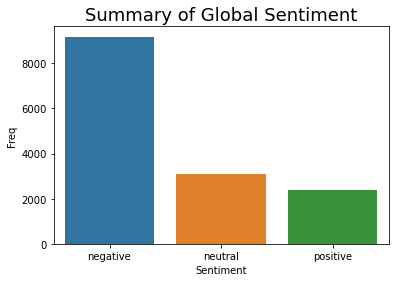

In [46]:
# summary of global sentiment
sns.countplot(x=df['airline_sentiment'].sort_values())
plt.ylabel('Freq')
plt.xlabel('Sentiment')
plt.title('Summary of Global Sentiment', fontsize=18)

In [47]:
# Tweets per airline in percent
tweets_per_airline = (df[['airline', 'text']].groupby('airline').count()/len(df['text'].notna().notnull())).sort_values(by='text', ascending=False)
tweets_per_airline

,text
airline,
United,0.261066
US Airways,0.198975
American,0.188456
Southwest,0.165301
Delta,0.151776
Virgin America,0.034426


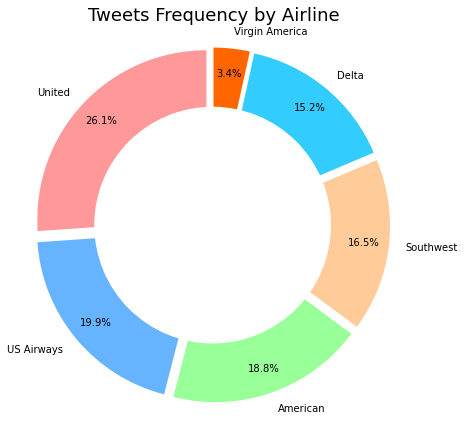

In [42]:
 
# Pie Chart of normalized tweets frequency for each airline
# Although, it is not recommended to use pie chart as visualization, 
# since they could be confusing and hard to understand, it doesn't hurt
# to learn how to do it

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#33ccff', '#ff6600']
fig1, ax1 = plt.subplots(figsize=(6.5, 6))
plt.pie(tweets_per_airline.text, labels=tweets_per_airline.index.values, autopct='%1.1f%%', 
startangle=90, colors=colors,
pctdistance=0.85, explode = [0.05]*tweets_per_airline.shape[0])
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
ax1.axis('equal')  
plt.tight_layout()
plt.title('Tweets Frequency by Airline', fontsize=18,);

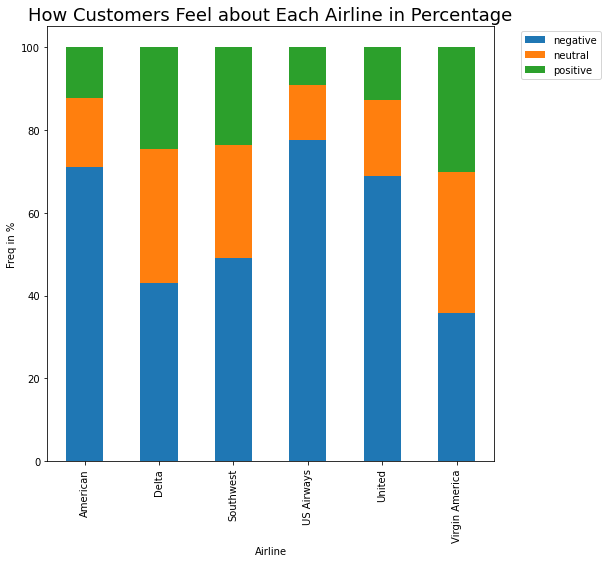

In [54]:
# Plot sentiment rates per airline
_ = pd.crosstab(df.airline, df.airline_sentiment).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar',title='How Customers Feel about Each Airline in Percentage',figsize=(8,8),stacked=True)
_.title.set_size(18)
_.set_xlabel('Airline')
_.set_ylabel('Freq in %')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);